<a href="https://colab.research.google.com/github/puaqieshang/automatic-labeling-heart-vessels/blob/master/confusion_matrix_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Update from Previous Version

* Added Confusion Matrix

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"
# !unzip -uq "/content/drive/My Drive/ldai-load.zip"
!unzip -uq "/content/drive/My Drive/processed_v3.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
'2020 Calendar.gsheet'
 3674B8D3-35D3-4B3F-9781-AA94068C55EF.jpeg
'Academic Results.gsheet'
 assign1_part1.pl
 assign1_part2.pdf
'Colab Notebooks'
'Energy Density - Kensington Campus UPDATED FOR 2020.xlsm'
'Energy Density - Kensington Campus vPractice.xlsm'
 IMG_7448.MOV
'Industrial Training'
'Introduction to Java Programming, Brief Version, 11th Global Edition.pdf'
"Ivan Pua's Past Projects"
 ldai-load-train.zip
 ldai-load.zip
'MECH3110 Best Group'
'MECH 3110

In [0]:
import os
import glob
import time
import helper
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
from torch import tensor, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("\nRunning on the GPU")
else:
    device = torch.device("cpu")
    print("\nRunning on the CPU")


Running on the GPU


# Develop Custom Dataset

In [0]:
class HeartVesselsDataset(Dataset):

    # Initialize your data, download, etc.
    def __init__(self, dest, folders):

        print(f"Making {dest} Data ...")
        data = defaultdict(dict)

        idCount = 0
        for folder in folders:

            if (folder == ".DS_Store"):
                continue
            
            file_des = f"{dest}/{folder}"
            all_files = os.listdir(file_des)
            # print(f"Folder {folder} containes {all_files}")

            os.chdir(file_des)
            for f in glob.glob("*.txt"):
                
                geometry = np.genfromtxt(f)
                # print(f"The file {f} has {geometry[0]}")              
                
                data[str(idCount)]['x'] = geometry
                data[str(idCount)]['y'] = folder

                idCount = idCount +1

            print(len(data))
            # print(f"AHG0003-3.txt has elements {data['AHG0003-3.txt']}")
            # print(data[f])
        
        self.len = len(data)
        self.data = data
        # print(f"1 has elements {data['1']}")

        # self.x_data = data # Access dict
        # self.y_data = data # Access dict

    # USE DICTIONARY
    def __getitem__(self, index):
        # print(index)
        geometry = self.data[str(index)]['x']
        label = self.data[str(index)]['y'] # Its a number
        # print(label)
        
        return geometry, tensor(int(label))

    def __len__(self):
        return len(self.data)


train_des = '/content/processed_v3/train'
train_folders = os.listdir(train_des)
train_dataset = HeartVesselsDataset(train_des, train_folders)
trainloader = DataLoader(dataset=train_dataset, batch_size=256,shuffle=True,num_workers=0)

test_des = '/content/processed_v3/val' # Use validation data because of split package
test_folders = os.listdir(test_des)
test_dataset = HeartVesselsDataset(test_des, test_folders)
testloader = DataLoader(dataset=test_dataset, batch_size=256,shuffle=True,num_workers=0)

print(f"Train has {len(trainloader)} data and Test has {len(testloader)} data")


Making /content/processed_v3/train Data ...
297
586
790
862
871
1159
1197
1682
1907
Making /content/processed_v3/val Data ...
33
65
87
95
96
128
132
185
210
Train has 8 data and Test has 1 data


Geo is of type <built-in method type of Tensor object at 0x7f20494ab288>
Label is of type <built-in method type of Tensor object at 0x7f20494a6240>
torch.Size([256, 100, 4])


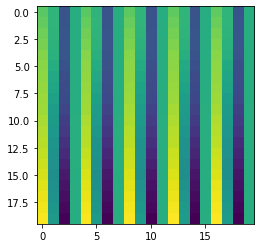

tensor(1)


In [0]:
'''
Test for resizing - Perhaps we can try different sizes?
'''

# print(trainloader)
geometries, label = next(iter(trainloader))
# print(geo)
print(f"Geo is of type {geometries.type}")
print(f"Label is of type {label.type}")
print(geometries.shape)

plt.imshow(geometries[0].view(20, 20))
plt.show()
print(label[0])

# Build Neural Network

Define your network architecture here



In [0]:
# Start Timer
t0 = time.time()

model = nn.Sequential(nn.Linear(400,128), nn.ReLU(), nn.Linear(128,64), 
                      nn.ReLU(), nn.Linear(64,9), nn.LogSoftmax(dim=1))
model = model.to(device)

In [0]:
# TODO: Create the network, define the criterion and optimizer
criterion = nn.NLLLoss()
optimiser = optim.SGD(model.parameters(), lr = 0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.003)
# optimizer = optim.Adam(model.parameters(), lr=0.001) # Can change learning rate
# loss_function = nn.MSELoss()

#Analysis

In [0]:
model = model.to(device)
criterion = nn.NLLLoss()
optimiser = optim.SGD(model.parameters(), lr = 0.001)

In [0]:
def accuracy(X, y):
    
    correct = 0
    total = 0
    vessels_count = np.zeros((9,), dtype=int)
    vessels_correct = np.zeros((9,), dtype=int)

    for i in (range(len(X))):
        real_class = y[i]
        # print(f"real class is {real_class}")

        vessels_count[real_class] += 1
        # ps = net(test_X[i].view(-1, 1, 20, 20))[0] 
        geom = X[i]
        geom = geom.resize_(1, 400)
            
        logps = model(geom.float()) # its in log bc of logSoftmax...
        ps = torch.exp(logps)  #.... that's why the probabilities need to be exp()
        predicted_class = torch.argmax(ps)

        if predicted_class == real_class:
            vessels_correct[real_class] += 1
            correct += 1

        total += 1

    return correct, total

def fwd_pass(loader, needsTraining): # for both train and test cases
    running_loss = 0
    sumCorrect = 0
    sumTotal = 0       
    for train_X, train_y in loader:
        # print(train_X.shape)
        train_X = train_X.view(train_X.shape[0], -1)
        train_X, train_y = train_X.to(device), train_y.to(device)
        
        if needsTraining is True:
            optimiser.zero_grad()
        
        output = model(train_X.float())
        loss = criterion(output,train_y)

        if needsTraining is True:
            loss.backward()
            optimiser.step()
        
        running_loss += loss.item()
        
        # train_loss.append(l)  

        # Accuracy
        correct, total = accuracy(train_X, train_y)
        sumCorrect += correct
        sumTotal += total
        # print(sumTotal)     

    l = running_loss/len(loader) #average loss for whole loader dataset
    acc = sumCorrect/sumTotal

    return acc, l

train_acc_list, train_loss_list, test_acc_list, test_loss_list = [], [],[],[]

# ROUNDS = 100
EPOCHS = 100
def analysis():

    for e in (range(EPOCHS)):

        train_acc, train_loss = fwd_pass(trainloader, needsTraining=True)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        with torch.no_grad():
            test_acc, test_loss = fwd_pass(testloader, needsTraining=False)

        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        print(f"Epoch {e} has test accuracy of {round(test_acc, 3)} and loss of {round(test_loss,3)}")
    
    # print(len(train_acc_list))

analysis()



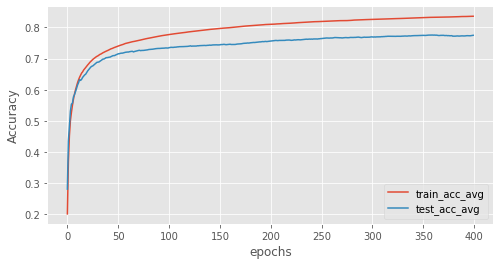

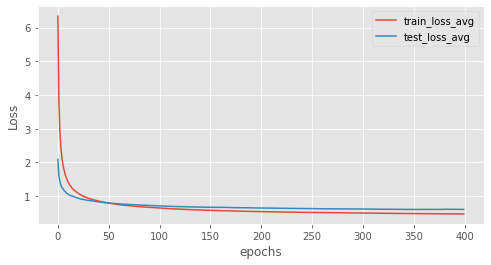

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

style.use("ggplot")

def create_acc_loss_graph():
    epoch = list(range(0, EPOCHS, 1))

    d = {'epochs': epoch,
        'train_acc': train_acc_list,
        'train_loss': train_loss_list,
        'test_acc': test_acc_list, 
        'test_loss': test_loss_list}

    df = pd.DataFrame(d)

    df['train_acc_avg'] = df['train_acc'].ewm(alpha=.02).mean()  # exponential weighted moving average
    df['test_acc_avg'] = df['test_acc'].ewm(alpha=.02).mean()
    df['train_loss_avg'] = df['train_loss'].ewm(alpha=.02).mean()
    df['test_loss_avg'] = df['test_loss'].ewm(alpha=.02).mean()



    # Then plot using pandas:
    df.plot(x='epochs', y=['train_acc_avg', 'test_acc_avg'], figsize=(8,4))
    plt.ylabel("Accuracy")
    df.plot(x='epochs', y=['train_loss_avg', 'test_loss_avg'], figsize=(8,4))
    plt.ylabel("Loss")

    plt.show()

create_acc_loss_graph()

In [0]:
t1 = time.time()
print(f"Time taken is {(t1-t0)/60} minutes.")

Time taken is 9.000318201382955 minutes.


# Train Neural Network

In [0]:
# TODO: Train the network here
train_loss =[]
def train(model):
    
    epochs = 30
    for e in range(epochs):
        
        running_loss = 0
        for train_X, train_y in trainloader:
            # print(train_X.shape)
            train_X = train_X.view(train_X.shape[0], -1)
            train_X, train_y = train_X.to(device), train_y.to(device)
            
            optimiser.zero_grad()
            
            output = model(train_X.float())
            loss = criterion(output,train_y)
            loss.backward()
            optimiser.step()
            
            running_loss += loss.item()
        else: 
            l = running_loss/len(trainloader)
            print(f"Epoch {e}: Training loss: {l}")
            train_loss.append(l)      
        
    
    print(len(train_loss))

train(model)

Epoch 0: Training loss: 7.350645184516907
Epoch 1: Training loss: 1.1180388629436493
Epoch 2: Training loss: 1.2025349959731102
Epoch 3: Training loss: 0.9091168344020844
Epoch 4: Training loss: 0.8976485282182693
Epoch 5: Training loss: 0.849799357354641
Epoch 6: Training loss: 0.8199204429984093
Epoch 7: Training loss: 0.821830153465271
Epoch 8: Training loss: 0.7785382345318794
Epoch 9: Training loss: 0.7690583094954491
Epoch 10: Training loss: 0.7569909691810608
Epoch 11: Training loss: 0.7578854709863663
Epoch 12: Training loss: 0.7926433980464935
Epoch 13: Training loss: 0.7321109920740128
Epoch 14: Training loss: 0.7222282961010933
Epoch 15: Training loss: 0.7283053547143936
Epoch 16: Training loss: 0.7250174731016159
Epoch 17: Training loss: 0.7135413065552711
Epoch 18: Training loss: 0.6919409185647964
Epoch 19: Training loss: 0.6966521441936493
Epoch 20: Training loss: 0.7051041647791862
Epoch 21: Training loss: 0.6803809925913811
Epoch 22: Training loss: 0.6857109144330025
E

# Test Neural Network

In [0]:
vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux']

def test(model):

    correct = 0
    total = 0
    vessels_count = np.zeros((9,), dtype=int)
    vessels_correct = np.zeros((9,), dtype=int)
    mainBifurcations_count = np.zeros((3,), dtype=int) 
    mainBifurcations_correct = np.zeros((3,), dtype=int) 

    predicted_class_array = []

    with torch.no_grad():

        for test_X, test_y in testloader:

            test_X, test_y = test_X.to(device), test_y.to(device)
            for i in tqdm(range(len(test_X))):
                real_class = test_y[i].item()
                # print(f"real class is {real_class}")

                vessels_count[real_class] += 1
                # ps = net(test_X[i].view(-1, 1, 20, 20))[0] 
                geom = test_X[i]
                geom = geom.resize_(1, 400)
                    
                logps = model(geom.float())
                ps = torch.exp(logps)  #probabilities
                predicted_class = torch.argmax(ps).item()
                predicted_class_array.append(predicted_class)

                if predicted_class is real_class:
                    vessels_correct[real_class] += 1
                    correct += 1
                
                else: 
                    # These numbers follow the sequence in the "vessels_name" list
                    # print(predicted_class)
                    if predicted_class in {0, 1, 2}: 
                        
                        if real_class in {0, 1, 2}:
                            # print(f"predicted {predicted_class}, real {real_class}")
                            mainBifurcations_correct[0] += 1

                    elif predicted_class in {3, 4}:
                        if real_class in {3, 4}:
                            # print(f"predicted {predicted_class}, real {real_class}")
                            mainBifurcations_correct[1] += 1
                    
                    elif predicted_class in {7, 8}:
                        if real_class in {7, 8}:
                            mainBifurcations_correct[2] += 1
                    else: 
                        continue

                total += 1

    print("\n\nOverall Accuracy is:", round(correct/total,3))
    print("------------------------")

    for i in range(len(vessels_count)):
        print(f"Accuracy of {vessels_names[i]} is:", round(vessels_correct[i]/vessels_count[i],3))

    print("------------------------")
    print(f"No of samples for each vessel in a batch is {vessels_count}")

    mainBifurcations_count[0] = vessels_count[0] + vessels_count[1] + vessels_count[2] #LCA
    mainBifurcations_count[1] = vessels_count[3] + vessels_count[4] #LCX
    mainBifurcations_count[2] = vessels_count[7] + vessels_count[8] #RCA 

    mainBifurcations_correct[0] += vessels_correct[0] + vessels_correct[1] + vessels_correct[2]  #LCA
    mainBifurcations_correct[1] += vessels_correct[3] + vessels_correct[4]  #LCX
    mainBifurcations_correct[2] += vessels_correct[7] + vessels_correct[8]  #RCA

    print("------------------------")
    print(f"Bifurcation LCA has accuracy of {round(mainBifurcations_correct[0]/mainBifurcations_count[0], 3)}")
    print(f"Bifurcation LCX has accuracy of {round(mainBifurcations_correct[1]/mainBifurcations_count[1], 3)}")
    print(f"Bifurcation RCA has accuracy of {round(mainBifurcations_correct[2]/mainBifurcations_count[2], 3)}")

    # print(test_y)
    return test_y, predicted_class_array


test_y, predicted_class_array = test(model)

100%|██████████| 210/210 [00:00<00:00, 2312.83it/s]



Overall Accuracy is: 0.812
------------------------
Accuracy of ldai is: 0.75
Accuracy of diags is: 0.939
Accuracy of septals is: 0.5
Accuracy of lcxi is: 0.812
Accuracy of obtmar is: 0.5
Accuracy of atrials is: 0.0
Accuracy of lcim is: 0.375
Accuracy of acutes is: 0.96
Accuracy of crux is: 0.906
------------------------
No of samples for each vessel in a batch is [32 33  4 32 22  1  8 25 53]
------------------------
Bifurcation LCA has accuracy of 0.942
Bifurcation LCX has accuracy of 0.981
Bifurcation RCA has accuracy of 1.0


# Testing Network for A Single Sample

tensor(8)
The actual vessel is crux


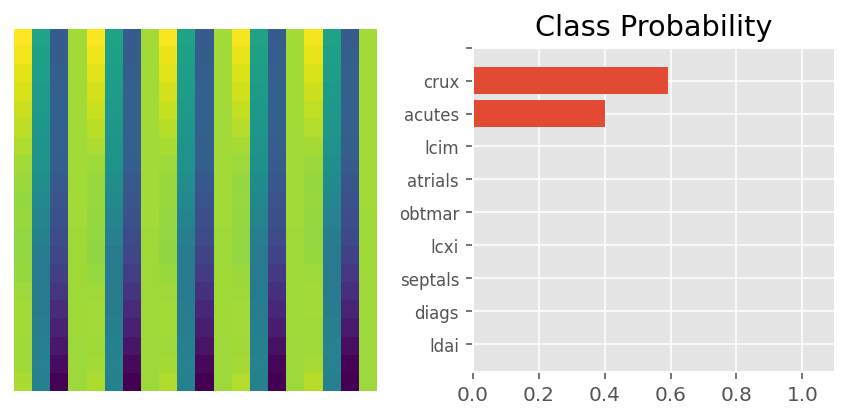

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(testloader)
geometries, labels = dataiter.next()
geom = geometries[0]
# Convert 2D matrix/image to 1D vector

geom = geom.resize_(1, 400)


# TODO: Calculate the class probabilities (softmax) for img
with torch.no_grad():
    
    logps = model(geom.cuda().float()) # convert to cuda tensor to run faster
    
ps = torch.exp(logps)

# Plot the image and probabilities

def view_classify(geom, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(geom.resize_(20, 20).numpy().squeeze()) #First figure on left
    
    ax1.axis('off')
    ax2.barh(np.arange(9), ps) #Make a horizontal bar plot
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(vessels_names, size='small');

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

geom_numpy = geom.cpu().numpy()
view_classify(geom.reshape(20, 20), ps) # convert back to numpy

print(labels[0])
print(f"The actual vessel is {vessels_names[labels[0]]}")


# More Analysis 

In [0]:
from sklearn import metrics

# True values
y_true = test_y.cpu()
# Predicted values
y_pred = predicted_class_array

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[24  5  1  1  0  0  0  0  1]
 [ 0 31  1  0  0  0  1  0  0]
 [ 0  1  2  1  0  0  0  0  0]
 [ 0  0  0 26  6  0  0  0  0]
 [ 0  0  0 10 11  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  4  0  3  0  0]
 [ 0  0  0  0  0  0  0 24  1]
 [ 0  0  0  0  0  0  0  5 48]]
              precision    recall  f1-score   support

           0      1.000     0.750     0.857        32
           1      0.838     0.939     0.886        33
           2      0.500     0.500     0.500         4
           3      0.650     0.812     0.722        32
           4      0.524     0.500     0.512        22
           5      0.000     0.000     0.000         1
           6      0.600     0.375     0.462         8
           7      0.828     0.960     0.889        25
           8      0.960     0.906     0.932        53

    accuracy                          0.805       210
   macro avg      0.655     0.638     0.640       210
weighted avg      0.811     0.805     0.802       210



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
